In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [8]:
#!pip install nltk

In [10]:
df = pd.read_csv('C:/Users/Owner/Desktop/git/Advertising/의류제품에 대한 소비자 리뷰/Consumer Review of Clothing Product/data_amazon.xlsx - Sheet1.csv')

In [12]:
df.head()

,Title,Review,Cons_rating,Cloth_class,Materials,Construction,Color,Finishing,Durability
0,NaN,Absolutely wonderful - silky and sexy and comf...,4.0,Intimates,0.0,0.0,0.0,1.0,0.0
1,NaN,Love this dress! it's sooo pretty. i happene...,5.0,Dresses,0.0,1.0,0.0,0.0,0.0
2,Some major design flaws,I had such high hopes for this dress and reall...,3.0,Dresses,0.0,0.0,0.0,1.0,0.0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5.0,Pants,0.0,0.0,0.0,0.0,0.0
4,Flattering shirt,This shirt is very flattering to all due to th...,5.0,Blouses,0.0,1.0,0.0,0.0,0.0


In [13]:
df.dtypes

Title            object
Review           object
Cons_rating     float64
Cloth_class      object
Materials       float64
Construction    float64
Color           float64
Finishing       float64
Durability      float64
dtype: object

In [14]:
df[['Cons_rating', 'Materials', 'Construction', 'Color', 'Finishing', 'Durability']].describe()

,Cons_rating,Materials,Construction,Color,Finishing,Durability
count,49124.000000,5741.000000,5743.000000,5742.000000,5737.000000,5734.000000
mean,4.099463,0.306567,0.504092,0.259840,0.265818,0.214161
std,1.283707,0.474515,0.500375,0.452657,0.441807,0.425305
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,5.000000,9.000000,2.000000,9.000000,1.000000,9.000000


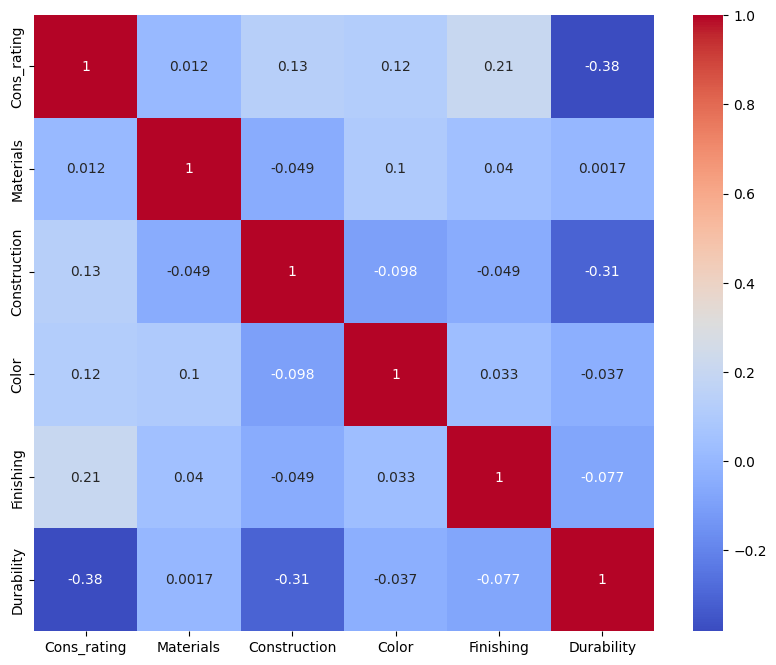

In [16]:
corr_matrix = df[['Cons_rating', 'Materials', 'Construction', 'Color', 'Finishing', 'Durability']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.show()

In [17]:
#데이터 탐색의 결론

#데이터셋에 대한 철저한 탐색과 분석 결과, 데이터셋의 변수들은 유의한 상관관계가 거의 또는 전혀 없는 것으로 나타났다. 이는 우리 데이터셋의 변수들이 대체로 서로 독립적이라는 것을 의미한다.

#이러한 연구 결과를 바탕으로, 추가 분석을 위해 리뷰, 평점 및 의류 유형에 초점을 맞출 것이다. 이러한 변수는 우리의 주제 분석에 가장 가치 있는 통찰력을 제공할 것이다. 리뷰 및 평점은 고객의 의견을 직접적으로 이해할 수 있는 반면, 의류 유형은 다양한 제품과 관련된 특정 트렌드 또는 선호도를 이해하는 데 도움이 될 수 있다.


Cloth_class
Dresses           8573
Blouses           5559
Knits             4829
Jeans             3962
Sweaters          3845
Pants             3665
Jackets           3226
Shorts            3084
Sleep             2924
Shirts            2543
Blazer            1788
Suits             1313
Fine gauge        1095
Skirts             943
Lounge             691
Swim               348
Outerwear          326
Legwear            165
Intimates          154
Layering           145
Trend              119
Dress               22
Casual bottoms       2
Chemises             1
Name: count, dtype: int64


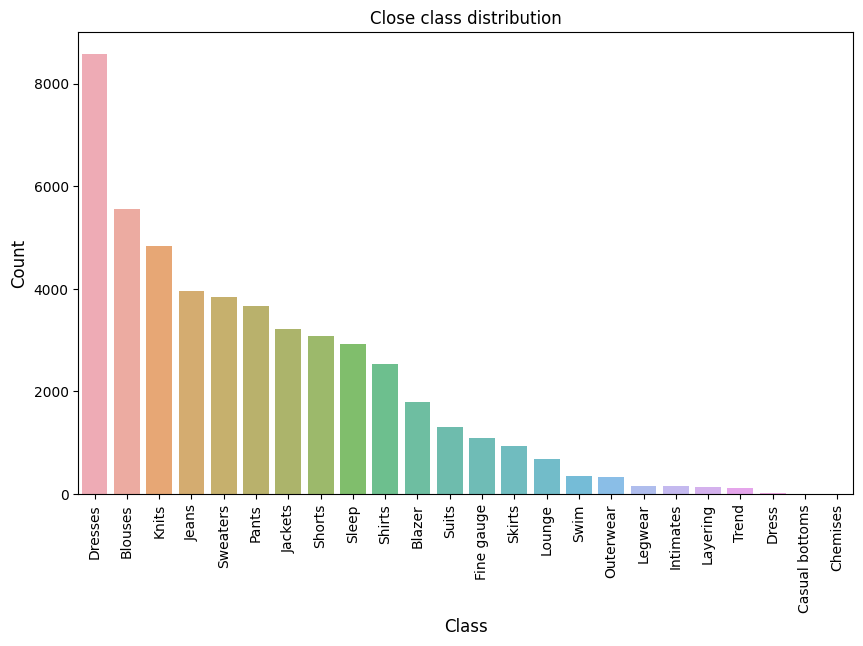

In [21]:
clothing_counts = df['Cloth_class'].value_counts()

print(clothing_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=clothing_counts.index, y=clothing_counts.values, alpha=0.8)
plt.title('Close class distribution')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.xticks(rotation=90)

plt.show()

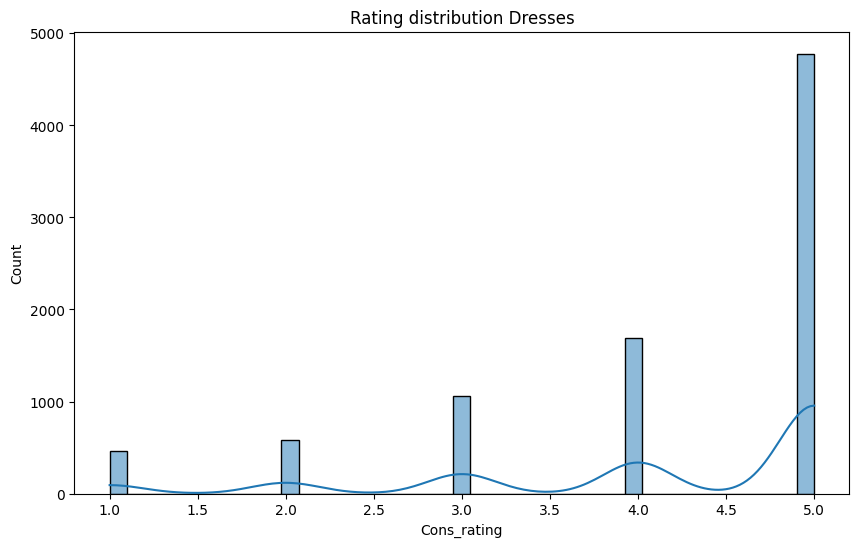

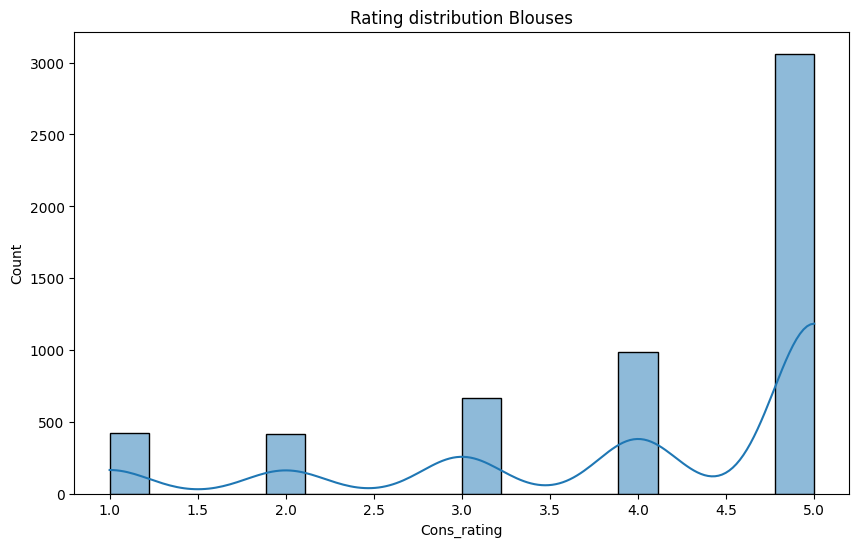

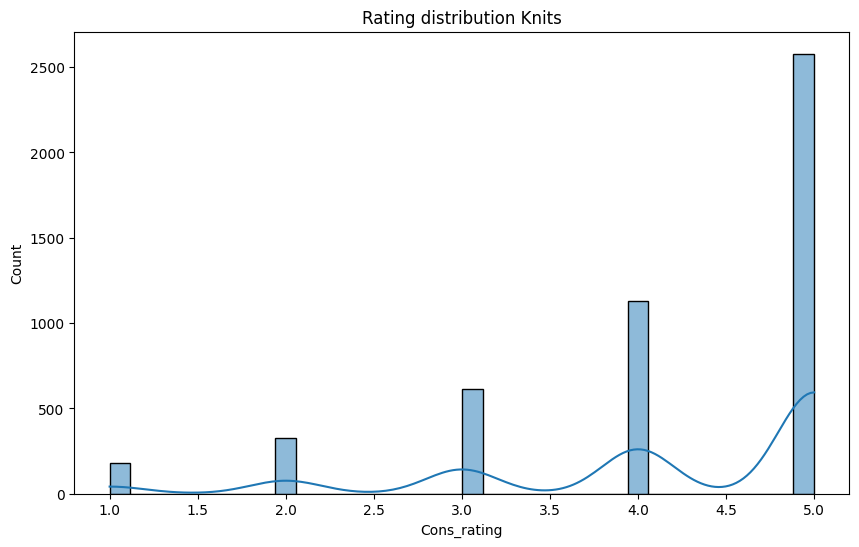

In [22]:
selected_data = df[df['Cloth_class'].isin(['Dresses', 'Blouses', 'Knits'])]

for cloth_type in ['Dresses', 'Blouses', 'Knits']:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=selected_data[selected_data['Cloth_class'] == cloth_type], x='Cons_rating', kde=True)
    plt.title(f'Rating distribution {cloth_type}')
    plt.show()

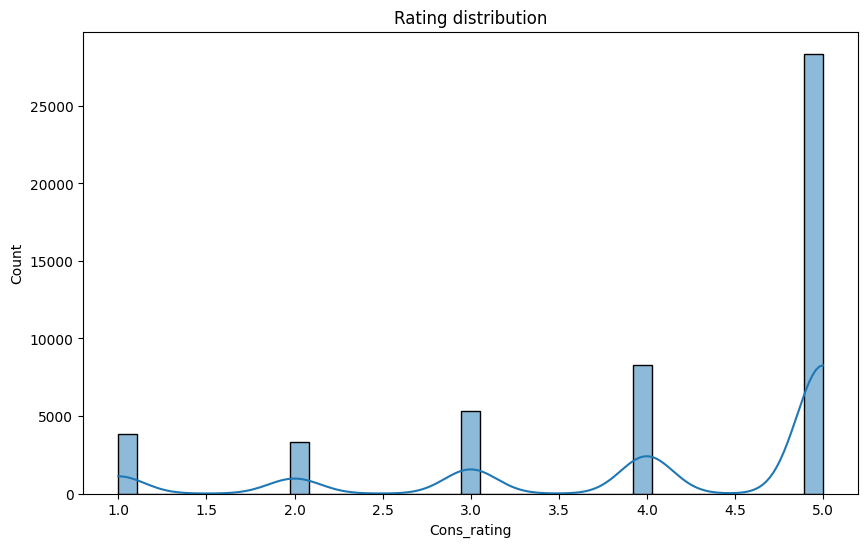

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Cons_rating', kde=True)
plt.title('Rating distribution')

plt.show()

In [25]:
from scipy import stats

rate = 1 / df['Cons_rating'].dropna().mean()

ks_statistic, p_value = stats.kstest(df['Cons_rating'].dropna(), 'expon', args=(0, rate))

print(f'KS-statistic: {ks_statistic}')
print(f'P-value: {p_value}')
print(f'Rate: {rate}')

KS-statistic: 0.9834184157916204
P-value: 0.0
Rate: 0.24393441320475515


In [26]:
#<0.05이므로 지수 분포이다. 이제 모든 종류의 옷에 대해 1000개 이상의 리뷰를 가진 테스트를 실시해 보자

In [27]:
from scipy import stats

clot_classes = ['Dresses', 'Blouses', 'Knits', 'Jeans', 'Sweaters', 'Pants', 'Jackets', 'Shorts', 'Sleep', 'Shirts', 'Blazer', 'Suits', 'Fine gauge']

for clot_class in clot_classes:
    df_class = df[df['Cloth_class'] == clot_class]
    rate = 1 / df_class['Cons_rating'].dropna().mean()
    ks_statistic, p_value = stats.kstest(df_class['Cons_rating'].dropna(), 'expon', args=(0, rate))
    print(f'Clot_class: {clot_class}')
    print(f'KS-statistic: {ks_statistic}')
    print(f'P-value: {p_value}')
    print(f'Rate: {rate}')
    print('------------------------')

Clot_class: Dresses
KS-statistic: 0.9840198198889473
P-value: 0.0
Rate: 0.24175576179864033
------------------------
Clot_class: Blouses
KS-statistic: 0.9826131992847574
P-value: 0.0
Rate: 0.24678903159859564
------------------------
Clot_class: Knits
KS-statistic: 0.9843968370458598
P-value: 0.0
Rate: 0.2403683424589348
------------------------
Clot_class: Jeans
KS-statistic: 0.9824358964601723
P-value: 0.0
Rate: 0.24740851754714624
------------------------
Clot_class: Sweaters
KS-statistic: 0.9845672741046223
P-value: 0.0
Rate: 0.23973542992636965
------------------------
Clot_class: Pants
KS-statistic: 0.9820455654534248
P-value: 0.0
Rate: 0.24876128419195007
------------------------
Clot_class: Jackets
KS-statistic: 0.9861604270655869
P-value: 0.0
Rate: 0.2336326767091541
------------------------
Clot_class: Shorts
KS-statistic: 0.9816307282391713
P-value: 0.0
Rate: 0.2501828822238478
------------------------
Clot_class: Sleep
KS-statistic: 0.9860444238325039
P-value: 0.0
Rate: 0.2

In [28]:
#보는 바와 같이, 그들은 모두 거의 동일한 모수 값인 0.24의 지수 분포를 가지고 있는데, 이는 그들 모두가 거의 동일한 추정치와 그 분포를 가지고 있다는 것을 의미한다.

In [29]:
nltk.download('stopwords')

stop_words = stopwords.words('english')

def preprocess_text(text, join_back=True):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Stop Words Cleaning
        if (
            token not in gensim.parsing.preprocessing.STOPWORDS and 
            token not in stop_words
        ):
            result.append(token)
    if join_back:
        result = " ".join(result)
    return result

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [30]:
# Let's apply preprocessing and see what some review will look like
reviews = df[df['Cloth_class'] == 'Dresses']['Review'].dropna()
reviews = reviews.apply(preprocess_text)
idx = 10

print(
    f"Result : {reviews.iloc[idx]}\n"
)

Result : upset price dress thought embroidered print fabric think cried little opened box ver pretty true size tad bit big tiny away color vibrant style unique skirt portion pretty poofy going forth mainly price quality definitely wish emb



In [31]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(2, 2))
data_vectorized = vectorizer.fit_transform(reviews)

lda_model = LatentDirichletAllocation(n_components=5)
lda_model.fit(data_vectorized)

feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Тема #{topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-6:-1]]))

Тема #1:
love dress true size fit perfectly looked like dress looks
Тема #2:
love dress dress beautiful fit perfectly dress fit highly recommend
Тема #3:
love dress beautiful dress true size dress perfect size small
Тема #4:
love dress true size great dress dress beautiful bought dress
Тема #5:
love dress true size bought dress dress fit dress fits


In [32]:
#대부분의 리뷰가 긍정적이기 때문에 대부분 긍정적인 리뷰를 받을 것이고, 그럼 평점 2점 이하의 드레스에 대한 리뷰를 분석해보자

In [33]:
bad_reviews = df[(df['Cloth_class'] == 'Dresses') & (df['Cons_rating'] < 2.5)]['Review'].dropna()
bad_reviews = bad_reviews.apply(preprocess_text)

bad_vectorizer = CountVectorizer(stop_words='english', ngram_range=(2, 2))
bad_data_vectorized = bad_vectorizer.fit_transform(bad_reviews)

bad_lda_model = LatentDirichletAllocation(n_components=5)
bad_lda_model.fit(bad_data_vectorized)

bad_feature_names = bad_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(bad_lda_model.components_):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([bad_feature_names[i] for i in topic.argsort()[:-6:-1]]))

Topic #1:
looks like looked like look like love dress wanted love
Topic #2:
looks like look like dress looks dress fabric dress received
Topic #3:
looked like loved dress looks like dress fit dress beautiful
Topic #4:
love dress runs small look like wanted love dress fit
Topic #5:
looked like wanted love love dress felt like dress looked


In [34]:
#결과가 명확하지 않고 결론을 내리기 어렵다는 것을 알 수 있으므로 Truncated SVD를 적용하여 결과가 개선되는지 알아보자

In [35]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000, min_df=10, stop_words='english')
X = vectorizer.fit_transform(bad_reviews)

lsa = TruncatedSVD(n_components=5)
X_lsa = lsa.fit_transform(X)

terms = vectorizer.get_feature_names_out()
for i, comp in enumerate(lsa.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:5]
    print("Topic "+str(i)+": ", end="")
    print(", ".join(t[0] for t in sorted_terms))

Topic 0: dress, like, fabric, size, fit
Topic 1: material, cheap, looks, like, fabric
Topic 2: material, cheap, small, size, tight
Topic 3: like, material, small, size, looked
Topic 4: fabric, cheap, small, size, looks


In [38]:
#이 결과는 이미 명백하며, 이를 통해 몇 가지 결론을 도출할 수 있다. 이 분석을 블라우스와 슈트에 적용해 보겠다

In [39]:
bad_reviews = df[(df['Cloth_class'] == 'Blouses') & (df['Cons_rating'] < 2.5)]['Review'].dropna()
bad_reviews = bad_reviews.apply(preprocess_text)

vectorizer = TfidfVectorizer(max_features=1000, min_df=10, stop_words='english')
X = vectorizer.fit_transform(bad_reviews)

lsa = TruncatedSVD(n_components=5)
X_lsa = lsa.fit_transform(X)

terms = vectorizer.get_feature_names_out()
for i, comp in enumerate(lsa.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:5]
    print("Topic "+str(i)+": ", end="")
    print(", ".join(t[0] for t in sorted_terms))

Topic 0: like, shirt, small, fit, fabric
Topic 1: small, size, runs, ordered, sizes
Topic 2: shirt, short, wear, black, stitching
Topic 3: material, shirt, small, cheap, like
Topic 4: like, small, looks, fabric, picture


In [40]:
bad_reviews = df[(df['Cloth_class'] == 'Suits') & (df['Cons_rating'] < 2.5)]['Review'].dropna()
bad_reviews = bad_reviews.apply(preprocess_text)

vectorizer = TfidfVectorizer(max_features=1000, min_df=10, stop_words='english')
X = vectorizer.fit_transform(bad_reviews)

lsa = TruncatedSVD(n_components=5)
X_lsa = lsa.fit_transform(X)

terms = vectorizer.get_feature_names_out()
for i, comp in enumerate(lsa.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:5]
    print("Topic "+str(i)+": ", end="")
    print(", ".join(t[0] for t in sorted_terms))

Topic 0: pants, size, suit, jacket, small
Topic 1: size, small, true, ordered, order
Topic 2: pants, jacket, small, item, vest
Topic 3: quality, material, like, small, fit
Topic 4: small, suit, fit, way, vest


In [41]:
#결과 해석: 주요 이슈 및 잠재적 솔루션 해결
#저등급 리뷰에 대한 주제 분석을 통해 고객이 관심을 가질 만한 세 가지 주요 분야를 확인했다.

#크기: 많은 고객들이 예상보다 의류 품목이 작다는 것을 발견했다.
#직물 품질: 제품에 사용된 직물의 품질에 만족하지 못하는 고객도 있었다.
#상품설명 : 온라인에 표시된 이미지와 실제 상품이 일치하지 않는 경우가 있었다.
#이러한 연구 결과를 바탕으로 다음과 같은 몇 가지 잠재적 해결책을 제시한다: